In [1]:
import glob
import os
from pyproj import Geod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
######################################
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
######################################

# Variables básicas
GRID_SIZE = 500
INTERP = GRID_SIZE*2
porcentajes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Constantes básicas globales
dir_raw = "./datos_filtrados_"
geod = Geod(ellps='WGS84')
lista_coords = {"BIO": (43.30, -2.91), "EAS": (43.36, -1.79), "PNA": (42.77, -1.64), "VIT": (42.88, -2.73)}
apt_len = len(lista_coords)
aeropuertos = lista_coords.keys()

# Iteramos todos los archivos, metemos los archvios en dataframes y en una lista
def cargar_datos():
    data = []
    for apt in aeropuertos:
        direccion_apt = dir_raw + apt
        for file_path in glob.glob(os.path.join(direccion_apt, "*.csv")):
            df = pd.read_csv(file_path)
            df['Destination'] = apt
            data.append(df)
    return data

all_data = cargar_datos()


# Obtener límites
def get_bounds(data):
    latitudes = list()
    longitudes = list()
    for df in data:
        latitudes.extend(df['Latitude'].tolist())
        longitudes.extend(df['Longitude'].tolist())
    return (min(latitudes), max(latitudes), min(longitudes), max(longitudes))

MIN_LAT, MAX_LAT, MIN_LON, MAX_LON = get_bounds(all_data)

print(MAX_LAT, MIN_LAT, MIN_LON, MAX_LON)

# Generar rejilla
def convertir_rejilla(lat, lon, min_lat, max_lat, min_lon, max_lon, grid_size):
    rej_x = int((lon - min_lon) / (max_lon - min_lon) * (grid_size - 1))
    rej_y = int((lat - min_lat) / (max_lat - min_lat) * (grid_size - 1))
    return rej_x, rej_y

def interpolar_rejilla(grid_points):
    interpolated_points = []
    for i in range(len(grid_points) - 1):
        x1, y1 = grid_points[i]
        x2, y2 = grid_points[i + 1]
        # Número de pasos
        num_steps = max(abs(x2 - x1), abs(y2 - y1))  
        # Interpolar
        x_interp = np.linspace(x1, x2, num_steps).astype(int)
        y_interp = np.linspace(y1, y2, num_steps).astype(int)
        interpolated_points.extend(list(zip(x_interp, y_interp)))
    return interpolated_points
                             
def crear_rejilla(data):
    resultados = []
    for df in data:
        # Convertir latitud-longitud a puntos rejilla.
        puntos = []
        for _, row in df.iterrows():
            x, y = convertir_rejilla(row['Latitude'], row['Longitude'], MIN_LAT, MAX_LAT, MIN_LON, MAX_LON, GRID_SIZE)
            puntos.append((x, y))
        trayectoria_continua = interpolar_rejilla(puntos)
        # Crear rejilla
        for percent in porcentajes:
            num_puntos = int(len(trayectoria_continua) * (percent / 100))
            rejilla = np.zeros((GRID_SIZE, GRID_SIZE))
            for x, y in trayectoria_continua[:num_puntos]:
                rejilla[y, x] = 1
            rejilla_sparse = csr_matrix(rejilla.reshape(GRID_SIZE * GRID_SIZE))
            resultados.append(rejilla_sparse)
    return resultados

# Separación test-train
encoder = LabelEncoder()
y_orig = [df['Destination'].iloc[0] for df in all_data]
y_encoded = encoder.fit_transform(y_orig)
y = tf.keras.utils.to_categorical(y_encoded, num_classes=apt_len)
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(all_data, y, test_size=0.5, random_state=42)
X_train = crear_rejilla(X_train_r)
X_val = crear_rejilla(X_val_r)
y_train = [it for it in y_train_r for _ in range(len(porcentajes))]
y_val = [it for it in y_val_r for _ in range(len(porcentajes))]


def imprimir_rejilla(rejillas, num):
    datos = rejillas[num].toarray().reshape(GRID_SIZE, GRID_SIZE)
    plt.imshow(datos, cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

"""
imprimir_rejilla(X_train, 0)
imprimir_rejilla(X_train, 4)
imprimir_rejilla(X_train, 8)
imprimir_rejilla(X_train, 9)"""

2025-07-28 09:07:50.911494: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 09:07:51.182301: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 09:07:51.364478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753693671.507955   17536 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753693671.548835   17536 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753693671.885012   17536 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

44.88902 41.29221 -5.04068 -0.20874


'\nimprimir_rejilla(X_train, 0)\nimprimir_rejilla(X_train, 4)\nimprimir_rejilla(X_train, 8)\nimprimir_rejilla(X_train, 9)'

In [ ]:
# Arquitectura del modelo
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(GRID_SIZE, GRID_SIZE, 1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(lista_coords), activation='softmax')
])

/home/224J5777santiago/TFM/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1752423241.299595 3292179 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752423241.303908 3292179 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def sparse_to_dense_batch(X_sparse, y_data, batch_size):
    for i in range(0, len(X_sparse), batch_size):
        X_batch = np.array([X_sparse[j].toarray().reshape(GRID_SIZE, GRID_SIZE, 1) for j in range(i, min(i+batch_size, len(X_sparse)))])
        y_batch = np.array(y_data[i:min(i+batch_size, len(y_data))])  # Match corresponding labels
        yield X_batch, y_batch

In [6]:
batch_size = 32 

from tensorflow.keras.callbacks import EarlyStopping # type: ignore

early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor
    min_delta=0.01,               # Minimum change to qualify as an improvement
    patience=3,                   # Number of epochs to wait without improvement
    verbose=1,                    # Logs a message when training stops
    restore_best_weights=True     # Revert to best weights after early stopping
)

train_data_generator = sparse_to_dense_batch(X_train, y_train, batch_size)
val_data_generator = sparse_to_dense_batch(X_val, y_val, batch_size)

train_dataset = tf.data.Dataset.from_generator(
    lambda: sparse_to_dense_batch(X_train, y_train, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, apt_len), dtype=tf.int32)
    )
).repeat()

validation_dataset = tf.data.Dataset.from_generator(
    lambda: sparse_to_dense_batch(X_val, y_val, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, apt_len), dtype=tf.int32)
    )
).repeat()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_dataset, 
          callbacks = [early_stopping],
          epochs=20, 
          validation_data=validation_dataset, 
          steps_per_epoch=int(np.ceil(len(X_train) / batch_size)), 
          validation_steps=int(np.ceil(len(X_val) / batch_size)))

Epoch 1/20


2025-07-13 20:46:52.483114: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: KeyError: np.int64(0)
Traceback (most recent call last):

  File "/home/224J5777santiago/TFM/.venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/home/224J5777santiago/TFM/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/224J5777santiago/TFM/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 290, in finalize_py_func
    generator_state.iterator_completed(iterator_id)

  File "/home/224J5777santiago/TFM/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]

KeyError: np.int64(0)


2025-07-13 20:46:52.483183: W tensorflow/core/kernels/data/generator_dataset_op.cc:109] Error occurred when

KeyboardInterrupt: 

In [2]:
from keras.models import load_model

model = load_model("modelo2D_3_capas.keras")

E0000 00:00:1753545005.263316 2407479 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753545005.319953 2407479 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
batch_size = 8
num_splits = len(porcentajes)
length_val = len(X_val)
subset_indices = [i % num_splits for i in range(length_val)]

for i, percent in enumerate(porcentajes):
    subset_X = [X_val[j] for j in range(length_val) if subset_indices[j] == i]
    subset_y = [y_val[j] for j in range(length_val) if subset_indices[j] == i]
    eval_dataset = tf.data.Dataset.from_generator(
        lambda: sparse_to_dense_batch(subset_X, subset_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(lista_coords)), dtype=tf.float32)
        )
    )
    test_loss, test_acc = model.evaluate(eval_dataset, steps=len(subset_X) // batch_size)
    print(f"Test Accuracy ({percent}): {test_acc:.4f}")

139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.7608 - loss: 0.7749
Test Accuracy (10): 0.7599
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.8040 - loss: 0.6397
Test Accuracy (20): 0.7896
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.7861 - loss: 0.7104
Test Accuracy (30): 0.7716
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.8170 - loss: 0.6006
Test Accuracy (40): 0.8183
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.8997 - loss: 0.3658
Test Accuracy (50): 0.8903
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9399 - loss: 0.2547
Test Accuracy (60): 0.9281
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9554 - loss: 0.1887
Test Accuracy (70): 0.9460
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9705 - loss: 0.1138
Test Accuracy (80): 0.9694
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9893 - loss: 0.0713
Test Accuracy (90): 0.9865
139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy:

1392/1392 ━━━━━━━━━━━━━━━━━━━━ 181s 130ms/step


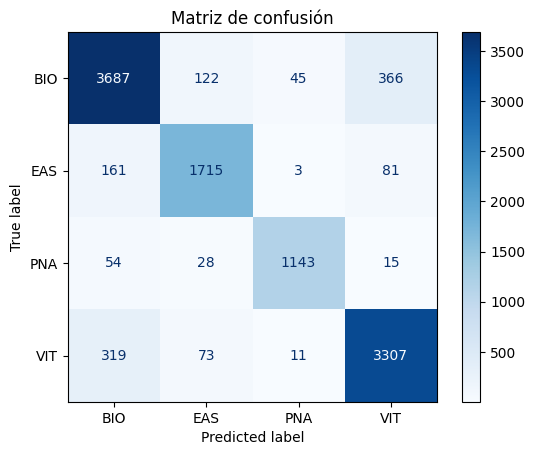

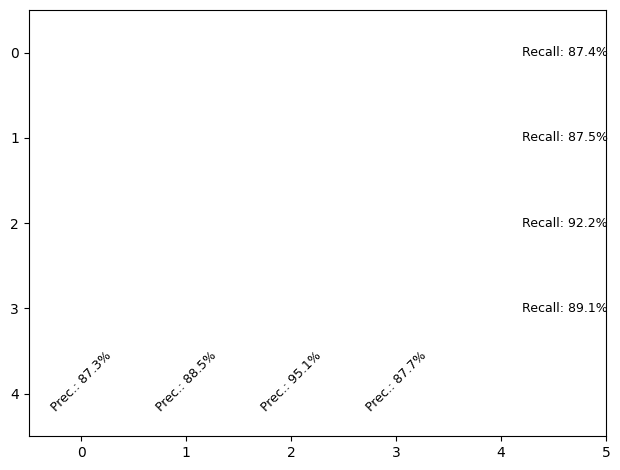

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

eval_dataset = tf.data.Dataset.from_generator(
    lambda: sparse_to_dense_batch(X_val, y_val, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32)  # assuming one-hot with 4 classes
    )
)

y_pred = model.predict(eval_dataset, steps=len(X_val) // batch_size + 1)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = np.array(y_val)
y_true_labels = np.argmax(y_true, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.show()

# Extra precisión y recall
recall = np.diag(cm) / np.sum(cm, axis=1)      # Recall = TP / (TP + FN)
precision = np.diag(cm) / np.sum(cm, axis=0)   # Precisión = TP / (TP + FP)
labels = encoder.classes_
n_classes = len(labels)

# --- Añadir anotaciones al gráfico generado por disp.plot() ---
import matplotlib.pyplot as plt

fig, ax = plt.gcf(), plt.gca()  # Obtener figura y ejes actuales del plot anterior

# Anotar recall al final de cada fila
for i in range(n_classes):
    ax.text(n_classes + 0.2, i, f"Recall: {recall[i]:.1%}", va='center', fontsize=9, color='black')

# Anotar precisión al final de cada columna
for i in range(n_classes):
    ax.text(i, n_classes + 0.2, f"Prec.: {precision[i]:.1%}", ha='center', fontsize=9, color='black', rotation=45)

# Ajustar límites para dejar espacio a las anotaciones
ax.set_xlim(-0.5, n_classes + 1)
ax.set_ylim(n_classes + 0.5, -0.5)

plt.tight_layout()
plt.show()


140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step


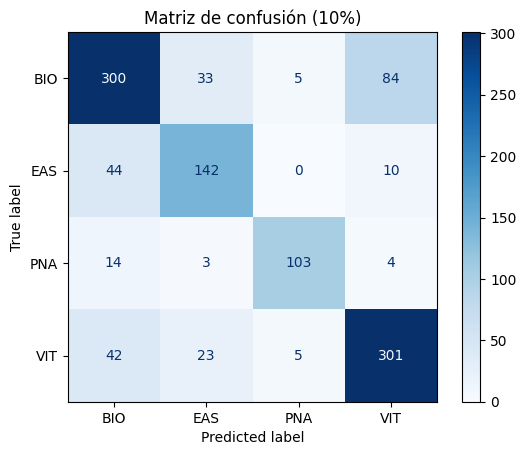

140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step


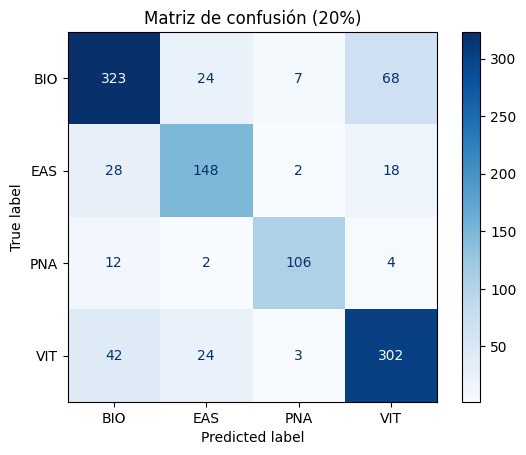

140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step


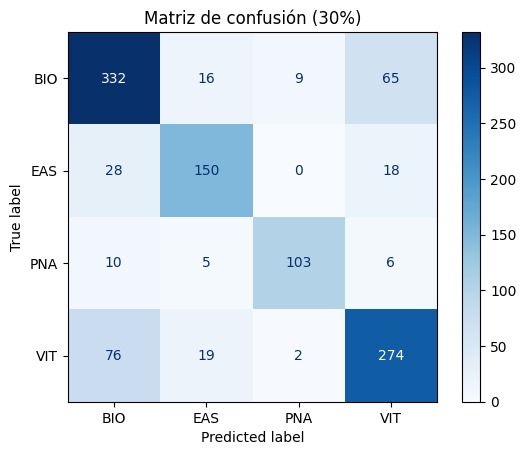

140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step


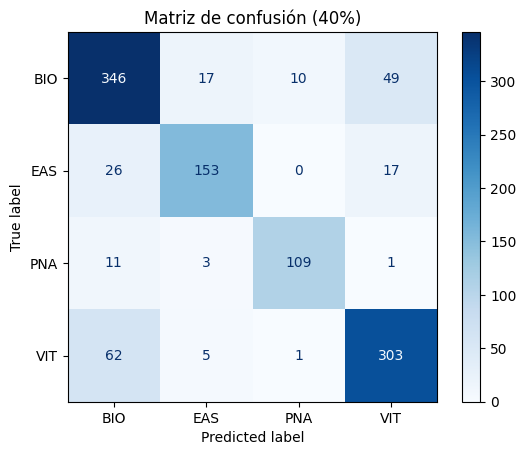

140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step


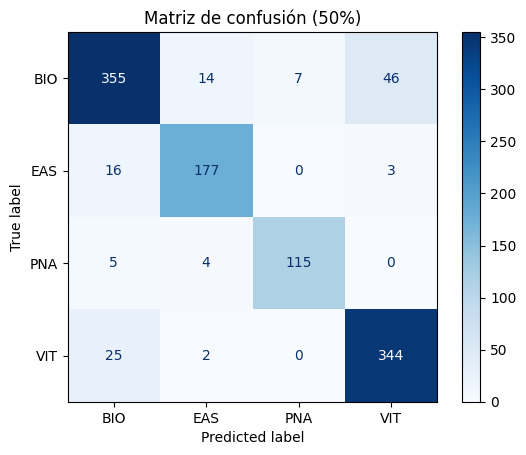

140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step


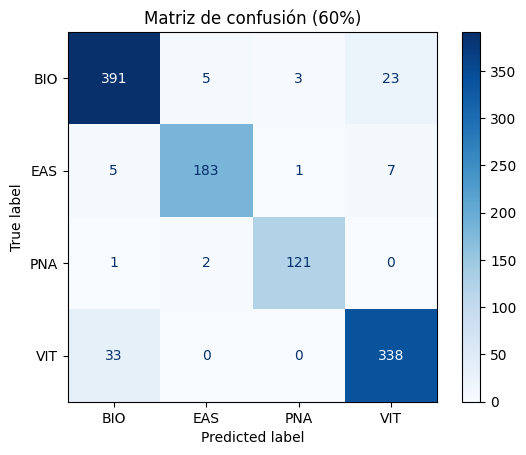

140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step


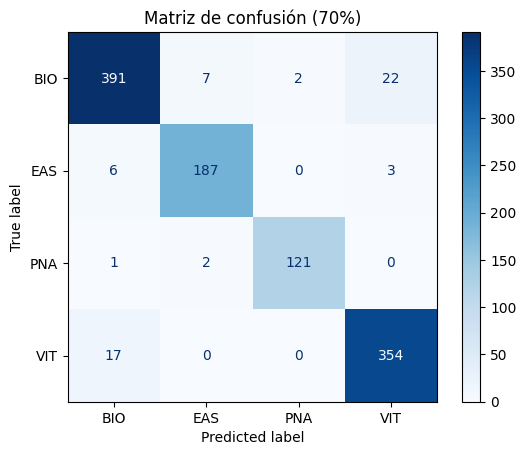

140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step


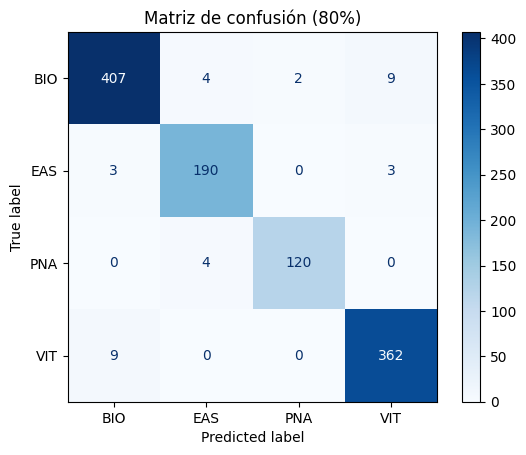

140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step


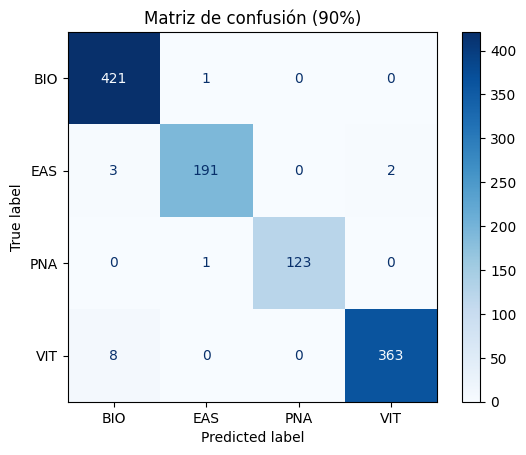

140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step


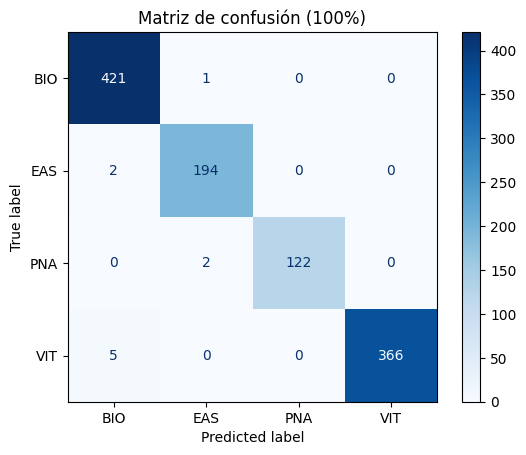

In [8]:
for i, percent in enumerate(porcentajes):
    subset_X = [X_val[j] for j in range(length_val) if subset_indices[j] == i]
    subset_y = [y_val[j] for j in range(length_val) if subset_indices[j] == i]

    eval_dataset = tf.data.Dataset.from_generator(
        lambda: sparse_to_dense_batch(subset_X, subset_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(lista_coords)), dtype=tf.float32)
        )
    )

    y_pred_probs = model.predict(eval_dataset, steps=len(subset_X) // batch_size + 1)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    y_true = np.array(subset_y)
    y_true_labels = np.argmax(y_true, axis=1)

    # Matriz de confusión
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión ({percent}%)")
    plt.show()


In [9]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize storage lists
airport_names = encoder.classes_
num_airports = len(airport_names)
recall_per_airport = [[] for _ in range(num_airports)]
precision_per_airport = [[] for _ in range(num_airports)]

for i, percent in enumerate(porcentajes):
    subset_X = [X_val[j] for j in range(length_val) if subset_indices[j] == i]
    subset_y = [y_val[j] for j in range(length_val) if subset_indices[j] == i]

    eval_dataset = tf.data.Dataset.from_generator(
        lambda: sparse_to_dense_batch(subset_X, subset_y, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, GRID_SIZE, GRID_SIZE, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_airports), dtype=tf.float32)
        )
    )

    y_pred_probs = model.predict(eval_dataset, steps=len(subset_X) // batch_size + 1)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    y_true = np.array(subset_y)
    y_true_labels = np.argmax(y_true, axis=1)

    # Compute per-class precision and recall
    precision = precision_score(y_true_labels, y_pred_labels, average=None, labels=range(num_airports))
    recall = recall_score(y_true_labels, y_pred_labels, average=None, labels=range(num_airports))

    for j in range(num_airports):
        precision_per_airport[j].append(precision[j])
        recall_per_airport[j].append(recall[j])


140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step


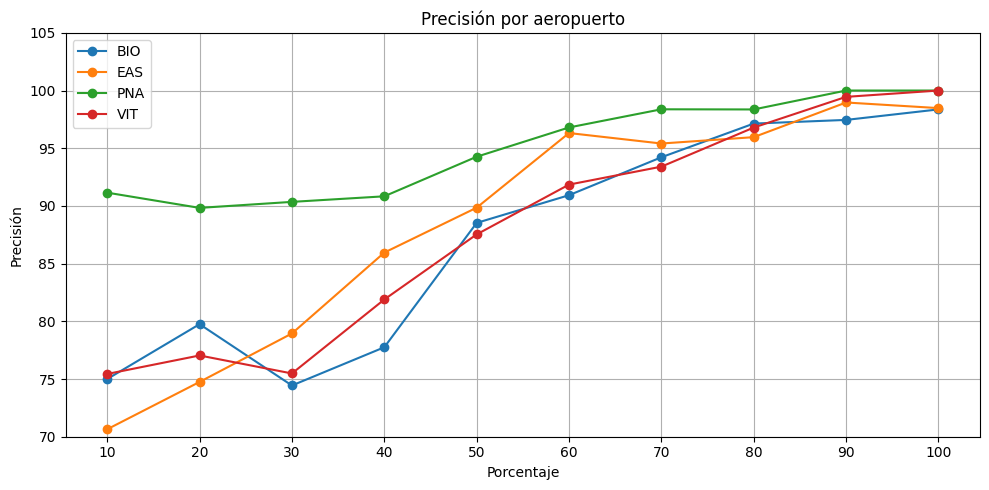

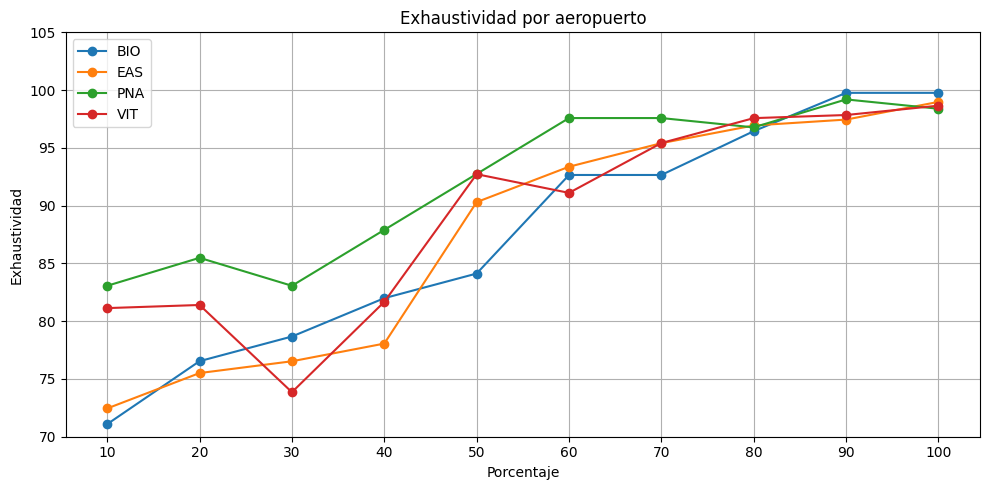

In [15]:

# Plot Precision
plt.figure(figsize=(10, 5))
for i, airport in enumerate(airport_names):
    plt.plot(porcentajes, [p * 100 for p in precision_per_airport[i]], marker='o', label=airport)
plt.title("Precisión por aeropuerto")
plt.xlabel("Porcentaje")
plt.ylabel("Precisión")
plt.ylim(70, 105)
plt.xticks(np.arange(10, 101, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Recall
plt.figure(figsize=(10, 5))
for i, airport in enumerate(airport_names):
    plt.plot(porcentajes, [p * 100 for p in recall_per_airport[i]], marker='o', label=airport)
plt.title("Exhaustividad por aeropuerto")
plt.xlabel("Porcentaje")
plt.ylabel("Exhaustividad")
plt.ylim(70, 105)
plt.xticks(np.arange(10, 101, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
